In [6]:
import os 

import fiona #must be import before geopandas
import geopandas as gpd
import rasterio
import rioxarray
import re
import rtree
import shapely
import pickle

#from cartopy import crs
import collections
import cv2
import math
from glob import glob
from tqdm.notebook import tqdm_notebook
import tqdm
# Standard packages
import tempfile
import warnings
import urllib
import shutil

# Less standard, but still pip- or conda-installable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from lxml.etree import Element,SubElement,tostring
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#import requests
from PIL import Image
from io import BytesIO
import tqdm
from skimage.metrics import structural_similarity as compare_ssim
import imutils

import psutil

import data_eng.az_proc as ap
import data_eng.form_calcs as fc

In [7]:
import os 

import fiona #must be import before geopandas
import geopandas as gpd
import rasterio
import rioxarray
import re
import rtree
import shapely
import pickle

#from cartopy import crs
import collections
import cv2
import math
from glob import glob
from tqdm.notebook import tqdm_notebook
import tqdm
# Standard packages
import tempfile
import warnings
import urllib
import shutil

# Less standard, but still pip- or conda-installable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from lxml.etree import Element,SubElement,tostring
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#import requests
from PIL import Image
from io import BytesIO
import tqdm
from skimage.metrics import structural_similarity as compare_ssim
import imutils

import psutil

import data_eng.az_proc as ap
import data_eng.form_calcs as fc

In [8]:
import shapely
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, MultiLineString
from shapely.geometry.collection import GeometryCollection
from shapely.ops import unary_union, polygonize

## File Paths

In [9]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"

tile_names_tile_urls_complete_array = np.load("image_download_azure/tile_name_tile_url_complete_array.npy")

tiles_labeled = "tile_name_tile_url_labeled.npy"
tiles_labeled_from_complete_set = np.load(tiles_labeled)

tracker_file_path = 'outputs/tile_img_annotation_annotator.npy'
tile_img_annotation = np.load(tracker_file_path)
tile_img_annotation_annotator = np.load("outputs/tile_img_annotation_annotator.npy")

tiles_errors = 'tile_name_tile_url_error_downloading.npy'
tiles_errors = np.load(tiles_errors)

#create folder to hold tiles in completed dataset

tiles_complete_dataset_path = os.path.join(parent_directory,"complete_dataset","tiles")
tiles_xml_complete_dataset_path = os.path.join(parent_directory,"complete_dataset","tiles_xml")
os.makedirs(tiles_complete_dataset_path, exist_ok=True)
tiles_xml_list = os.listdir(tiles_xml_complete_dataset_path)
new_tiles_xml_complete_dataset_path = os.path.join(parent_directory,"complete_dataset","tiles_xml_merged")

tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")
image_characteristics = pd.read_csv("image_characteristics.csv")
tile_names_tile_urls_complete_array_unique_standard_tile_names = np.load("tile_names_tile_urls_complete_array_unique_standard_tile_names.npy")

#NAIP quad map
quad_indicies_path = "C:/Users/rapiduser/Box/EPA STAR 2019 (Community Resistance to Environmental Disasters)/Data/AST Datasets/MapIndices_National_GDB/MapIndices_National_GDB.gdb"
#fiona.listlayers(quad_indicies_path)
rechipped_image_path = os.path.join(parent_directory,"temp/rechip")

folders_of_images_xmls_by_tile = os.listdir(rechipped_image_path)
images_and_xmls_by_tile_path = rechipped_image_path

In [65]:
tiles_dir = tiles_complete_dataset_path
tiles_xml_path = tiles_xml_complete_dataset_path
item_dim = int(512)

In [70]:
tile_names_by_tile = []
tile_paths_by_tile = []
tile_heights = []
tile_widths = []
tile_depths = []

min_lon_tile = [] #NW_coordinates
min_lat_tile = []  #NW_coordinates
max_lon_tile = [] #SE_coordinates
max_lat_tile = [] #SE_coordinates

chip_names = []
tile_names_by_chip = []
tile_paths_by_chip = []
NW_coordinates_pixel = []
SE_coordinates_pixel = []
NW_coordinates_lonlat = []
SE_coordinates_lonlat = []
row_indicies = []
col_indicies = []
image_paths  = []
xml_paths = []

item_dim = int(512)


In [ ]:
def merge_tile_annotations(tiles_xml_list, tiles_xml_dir, new_tiles_xml_dir, distance_limit):
    # https://stackoverflow.com/questions/55593506/merge-the-bounding-boxes-near-by-into-one
    for tile_xml in tqdm.tqdm(tiles_xml_list):
        #save bboxes and characteristics
        trunc_diff_objs_bbox = []
        trunc_diff_objs_characteristics = []
        remaining_objs_bbox = []
        remaining_objs_characteristics = []
        #lists for geosons/geodatabase
        polygon_id = []
        tile_names = []
        object_class = []
        merged_bbox = []
        geometry = []
        #get tilename/tile xml path
        tile_name = os.path.splitext(tile_xml)[0]
        tile_xml_path = os.path.join(tiles_xml_dir, tile_xml)
        #load tile characteristics 
        tile_characteristics_subset = tile_characteristics[tile_characteristics.loc[:,"tile_name"] == tile_name]
        tile_lat_array = np.linspace(tile_characteristics_subset["min_lat_tile"].values[0], 
                                     tile_characteristics_subset["max_lat_tile"].values[0],
                                     tile_characteristics_subset["tile_heights"].values[0])

        tile_lon_array = np.linspace(tile_characteristics_subset["min_lon_tile"].values[0], 
                                     tile_characteristics_subset["max_lon_tile"].values[0],
                                     tile_characteristics_subset["tile_widths"].values[0])
        #load each xml
        tree = et.parse(tile_xml_path)
        root = tree.getroot()
        #get the bboxes
        for obj in root.iter('object'):
            xmlbox = obj.find('bndbox')
            obj_xmin = xmlbox.find('xmin').text
            obj_ymin = xmlbox.find('ymin').text
            obj_xmax = xmlbox.find('xmax').text
            obj_ymax = xmlbox.find('ymax').text
            #get truncated bboxes
            if (int(obj.find('difficult').text) == 1) or (int(obj.find('truncated').text) == 1):
                #get bboxes/characteristics
                trunc_diff_objs_bbox.append([obj_xmin, obj_ymin, obj_xmax, obj_ymax])
                trunc_diff_objs_characteristics.append([obj.find('name').text, obj.find('pose').text, 
                                                        obj.find('truncated').text, obj.find('difficult').text])
            else:        
                remaining_objs_bbox.append([obj_xmin, obj_ymin, obj_xmax, obj_ymax])
                remaining_objs_characteristics.append([obj.find('name').text, obj.find('pose').text, 
                                                       obj.find('truncated').text, obj.find('difficult').text])
        #merge where possible
        trunc_diff_objs_bbox = np.array(trunc_diff_objs_bbox).astype(np.int32)
        trunc_diff_objs_bbox = trunc_diff_objs_bbox.tolist()
        bool_, merged_characteristics, merged_bboxes =  merge_algo(trunc_diff_objs_characteristics,trunc_diff_objs_bbox,distance_limit)
        
        count = 0
        #add merged bboxes
        for j, (char, bbox) in enumerate(zip(merged_characteristics, merged_bboxes)):
            polygon_id.append(tile_name + "_" + str(count).zfill(4)) # The index is a six-digit number like '000023'.
            tile_names.append(tile_name)
            object_class.append(char[0])
            merged_bbox.append(True)
            min_lon = tile_lon_array[bbox[0]]
            max_lon = tile_lon_array[bbox[2]]
            min_lat = tile_lat_array[bbox[1]]
            max_lat = tile_lat_array[bbox[3]]
            geometry.append(Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)]))
            count += 1

        #add remaining bboxes
        for j, (char, bbox) in enumerate(zip(remaining_objs_bbox, remaining_objs_characteristics)):
            polygon_id.append(tile_name + "_" + str(count).zfill(4)) # The index is a six-digit number like '000023'.
            tile_names.append(tile_name)
            object_class.append(char[0])
            merged_bbox.append(False)
            min_lon = tile_lon_array[bbox[0]]
            max_lon = tile_lon_array[bbox[2]]
            min_lat = tile_lat_array[bbox[1]]
            max_lat = tile_lat_array[bbox[3]]
            geometry.append(Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)]))
            count += 1
    return(polygon_id, tile_names, object_class, 
           merged_bbox, geometry)

In [ ]:
#add merged bboxes
geometry = []
for i, (char, bbox) in enumerate(zip(objs_characteristics, objs_bbox)):
    geometry.append(Polygon([(bbox[0],bbox[1]),(bbox[0],bbox[3]),(bbox[2],bbox[3]),(bbox[2],bbox[1])]))

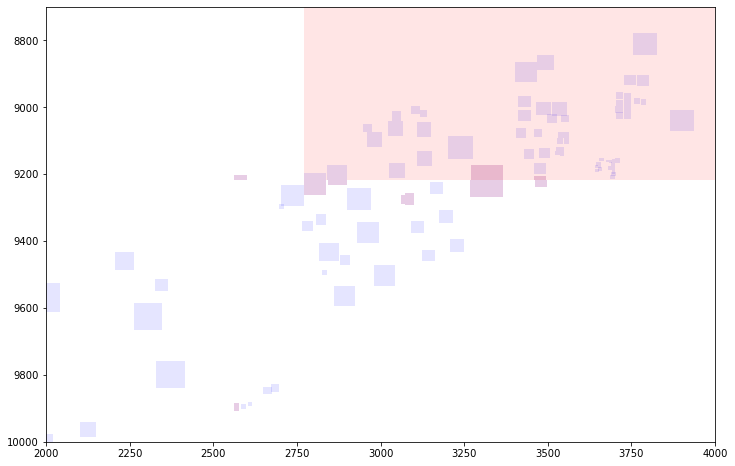

In [75]:
fig,  axs = plt.subplots(figsize = (20,8),sharex= True,sharey= True)
for polygon in geometry:
    p = gpd.GeoSeries(polygon)
    p.plot(ax=axs, alpha=0.1,color ="blue")
for polygon in merged_geometry:
    p = gpd.GeoSeries(polygon)
    p.plot(ax=axs, alpha=0.1,color="red")
plt.xlim(2000,4000)
plt.ylim(8700,10000)
plt.gca().invert_yaxis() #https://stackoverflow.com/questions/1349230/matplotlib-coord-sys-origin-to-top-left
plt.show()

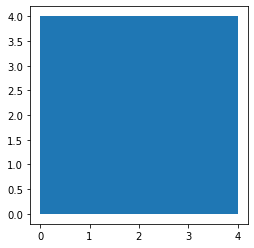

In [7]:

plt.show()